                                            import needed modules

In [1]:
%matplotlib inline

from utils import *
from main_second import *
import json
import matplotlib.pyplot as plt
import numpy as np

                                read, pre-process and draw power consumption data

In [ ]:
data = read_csv('Electricity_BME.csv')
work_data = data[len(data) // 2:]
future_data = data[:len(data) // 2]
for i in range(1, len(work_data)):
    if work_data[i]['Pt'] - work_data[i - 1]['Pt'] <= 0:
        work_data[i]['St'] = work_data[i - 1]['St']
        work_data[i]['Pt'] = work_data[i - 1]['Pt']
        work_data[i]['Qt'] = work_data[i - 1]['Qt']
for i in range(1, len(future_data)):
    if future_data[i]['Pt'] - future_data[i - 1]['Pt'] <= 0:
        future_data[i]['St'] = future_data[i - 1]['St']
        future_data[i]['Pt'] = future_data[i - 1]['Pt']
        future_data[i]['Qt'] = future_data[i - 1]['Qt']
first_consumption = calculate_average_power(
    [work_data[i]['St'] - work_data[i - 1]['St'] for i in range(1, len(work_data))],
    time='month'
)
second_consumption = calculate_average_power(
    [future_data[i]['St'] - future_data[i - 1]['St'] for i in range(1, len(future_data))],
    time='month'
)
fig, ax = plt.subplots()
labels = [x for x in range(1, 13)]
x = np.arange(len(labels))
rects1 = ax.bar(x - 0.35/2, first_consumption, 0.35, label='First year (data for training)')
rects2 = ax.bar(x + 0.35/2, second_consumption, 0.35, label='Second year')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values, Watt')
ax.set_title('Power consumption')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

                                        define inputs for neural network

In [3]:
cofs_delta = dict()
cofs = dict()
for key in ['Pt', 'Qt', 'St']:
    cofs_delta[key] = (
        min([work_data[i][key] - work_data[i - 1][key] for i in range(1, len(work_data))]),
        max([work_data[i][key] - work_data[i - 1][key] for i in range(1, len(work_data))])
    )
for key in ['V', 'I', 'f', 'DPF', 'APF', 'P', 'Q', 'S']:
    cofs[key] = (
        min([work_data[i][key] for i in range(1, len(work_data))]),
        max([work_data[i][key] for i in range(1, len(work_data))])
    )
inputs = list()
for i in range(1, len(work_data)):
    inputs.append([])
    for key, value in cofs.items():
        inputs[-1].append((work_data[i][key] - value[0]) / (value[1] - value[0]))
    for key, value in cofs_delta.items():
        inputs[-1].append((work_data[i][key] - work_data[i - 1][key] - value[0]) / (value[1] - value[0]))

                                        initialize neural network

In [4]:
dataset = inputs
n_inputs = len(dataset[0]) - 1
n_outputs = len(set([row[-1] for row in dataset]))
try:
    with open('neural_network.json', 'r') as file:
        network = list(json.load(file))
except:
    network = initialize_network(n_inputs, 10, 1)

                                      neural train and weights update part

In [5]:
train_network(network, dataset, 0.3, 1)
with open('neural_network.json', 'w') as file:
    json.dump(network, file)

                                 calculate power consumption with neural network

In [16]:
actually_values = list()
expected_values = list()
for vector in inputs:
    actually = forward_propagate(network, vector)[0]
    actually = actually * (cofs_delta['St'][1] - cofs_delta['St'][0]) + cofs_delta['St'][0]
    expected = vector[-1] * (cofs_delta['St'][1] - cofs_delta['St'][0]) + cofs_delta['St'][0]
    actually_values.append(actually)
    expected_values.append(expected)
avg_actual = calculate_average_power(actually_values, time='month')
avg_expected = calculate_average_power(expected_values, time='month')
for row_actual, row_expected in zip(avg_actual, avg_expected):
    try:
        relative_error = abs(row_expected - row_actual) / row_expected * 100
    except ZeroDivisionError as e:
        relative_error = 'no result'
    print('actually: {:.6}   expected: {:.6}   relative error: {:.6} %'.format(row_actual,
                                                                               row_expected,
                                                                               relative_error))

actually: 28607.1   expected: 26159.0   relative error: 9.35865 %
actually: 22006.6   expected: 19609.0   relative error: 12.2269 %
actually: 25670.4   expected: 22329.0   relative error: 14.9645 %
actually: 25064.9   expected: 27032.0   relative error: 7.27702 %
actually: 15885.1   expected: 13290.0   relative error: 19.5265 %
actually: 22892.8   expected: 20317.0   relative error: 12.6779 %
actually: 31188.7   expected: 28384.0   relative error: 9.88144 %
actually: 26123.5   expected: 22959.0   relative error: 13.7831 %
actually: 25200.0   expected: 22292.0   relative error: 13.0449 %
actually: 25913.4   expected: 22393.0   relative error: 15.7212 %
actually: 20044.0   expected: 16588.0   relative error: 20.8344 %
actually: 48253.6   expected: 44669.0   relative error: 8.02478 %


                               draw histogram with actual and expected power consumption

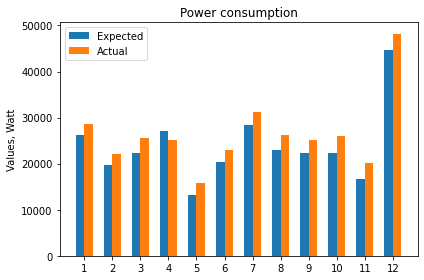

In [17]:
fig, ax = plt.subplots()
labels = [x for x in range(1, 13)]
x = np.arange(len(labels))
rects1 = ax.bar(x - 0.3 / 2, avg_expected, 0.3, label='Expected')
rects2 = ax.bar(x + 0.3 / 2, avg_actual, 0.3, label='Actual')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values, Watt')
ax.set_title('Power consumption')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()